In [1]:
import sys
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

# plt.style.use('whitegrid')
sns.set_style('whitegrid')

matplotlib.rcParams.update({'figure.figsize': (10, 6)})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})

%config InlineBackend.figure_format = 'retina'

# Machine Learning lab 5: evaluation and multi-layer perceptron 
## Jake Rowland and Paul Herz
2017-10-20

> **Nota bene:** much of this introductory text that describes the classification task and dataset preparation is replicated from our previous project, which in turn is heavily based upon the logic and processes from our first project, as all three share the same dataset, and we do not wish to produce new and redundant boilerplate to describe that same dataset.

## 1. Introduction

*Partially reproduced from Lab 4, with additional notes on problems discovered since and our approach to preserving consistency*

Here we return to the dataset of our initial project, [Exploring Table Data](https://github.com/SMU-ML-2017/Project1/blob/master/ML%20Lab%201.ipynb), wherein we graphically analyzed the trends in the [IMDB Top 5000 Movie Dataset](https://www.kaggle.com/deepmatrix/imdb-5000-movie-dataset). One aspect of our analysis in that project centered around dividing the set of films into three groups: **poor**, **average**, and **good**. This was a simplification of IMDB's 10-point rating system, and grouped films into asymmetric quantiles. It allowed us to cut arbitrary lines in the large group of films to illustrate trends among the upper percentile films versus the rest. 

In our fourth project, we employed several classification techniques to predict how the properties of a movie's production applied to its classification under these three labels. We came to the realization, very late in the project, that the performance of our classifier was much poorer than expected when operating upon this dataset and this classification task. In our post-mortem review, we came to the conclusion that this was not the fault of our homespun logistic regression classifier, but an inherent issue in how we handled the dataset. We make no claim that there is a fundamental issue with the source dataset, but the method with which we applied abritrary class labels onto the dataset was **fundamentally flawed**. Instead of separating well-defined clusters of films based on any number of properties, we delineated films, as described above, with percentiles on a normal distribution. Not only did this lead to significant class imbalance, but almost identical data points were separated along arbitrary lines.

We did **not** attempt to change this labeling process in our fourth project for the sake of consistency, even though we already somewhat understood from visualizations in our first project that this method was flawed and would negatively effect performance of any classifiers. For the same reason, **we will not modify our flawed labelling approach here**, if only so that classification methods used here can be fairly compared with methods in our fourth project. Changing our arbitrary labelling approach, or even our dataset in this project would better serve our metrics but threaten the usefulness of this report in the context of our other reports.

Here, we will use this classification task on the films dataset to illustrate the performance and functionality of a homespun multilayer perceptron implementation, as well as to outline our processes for cross-validation and evaluation.

### 1.1 Background

*Wholly reproduced from Lab 4*

This dataset represents data compiled entirely by IMDB, whose primary purpose is as a compendium of films. In the previous use of this dataset, we mostly considered how this dataset serves as a representation of trends in American and international cinema. This time, we want to consider the films more in the context of IMDB as an application, and the trends of American film consumers.

### 1.2 Business Case

*Wholly reproduced from Lab 4*

Using the same arbitrary classifications of **poor**, **average**, and **good**, whose definitions depend on the quantile groupings of IMDB out-of-10 scores, we want to use film data (less the scores) to predict a film's classification into one of these groups. We believe that such a feature will be useful to IMDB, which is likely to receive a sizeable portion of traffic from visitors looking up brand-new films. However, brand-new films do not have sufficient reviews for IMDB to formulate their composite out-of-ten score, and must display a placeholder until there is consensus among a statistically significant number of film critics. Instead of leaving users dissatisfied when they cannot quickly determine whether they should see the film, or how it is performing, IMDB can classify the movie as "probably bad," "probably average," or "probably good." This is not as a replacement to critic composites, but to fill in the blank before reviews come in. 

This capability, to preemptively label new material based on relevant input data like directors, budgets, etc. is of great value to IMDB, and although there is a definite threshold of performance required for meaningful utility of the prediction task, there is no risk presented to IMDB. In the worst-case situation, IMDB provides a preliminary rating that is not quite in line with the forthcoming critics' reviews. What would befall IMDB is akin to what would befall the publisher of a critic whose review is an outlier—absolutely nothing. In the best-case situation, this preemptive rating adds value to the IMDB platform as it advises moviegoers on the probable quality of brand-new films, which will increase traffic and therefore advertisement revenue.

### 1.3 Serviceability

*Wholly reproduced from Lab 4*

As it was mentioned, this task and its implementation as a value-adding tool in the IMDB interface presents virtually no risk to IMDB, even if it were to perform poorly. However, there is a definite point in the range of possible performance at which the product becomes *useful*. We believe that our model must be 80% accurate to gain public trust when our preemptive ratings are referred to — a 1 in 5 chance of predicting a movie to be poor/average/good when it is not. This number may seem arbitrary, but it is our best approximation of an error rate that an end user would be willing to tolerate.

## 2. The dataset: preprocessing and review

*Partially reproduced from Lab 4*

### 2.1 Dataset preparation

Below, we load the dataset and reorder columns in a more reasonable fashion.

In [2]:
m = pd.read_csv('movie_metadata.csv')

# Reorder the DataFrame to a more intelligent fashion
m = m[[
    'movie_title','title_year',
    'genres', 'plot_keywords', 'duration',
    'budget', 'gross',
    'language', 'country', 'content_rating',
    'color', 'aspect_ratio',
    'facenumber_in_poster',
    'director_name',
    'actor_1_name', 'actor_2_name', 'actor_3_name',
    'movie_facebook_likes', 'director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
    'actor_3_facebook_likes', 'cast_total_facebook_likes',
    'movie_imdb_link', 'num_user_for_reviews', 'num_critic_for_reviews', 'num_voted_users',
    'imdb_score',
]]

Additionally, we cast integral data columns out of the default float type, to ensure the data is best represented by the right type. We follow by removing duplicates, and then copying the dataset before further destructive preprocessing.

In [3]:
# Reduce the number of float64 data types for columns that do not need a float64 data type
for col in ['title_year','facenumber_in_poster',
'movie_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes',
'actor_3_facebook_likes','cast_total_facebook_likes','num_user_for_reviews',
'num_critic_for_reviews','num_voted_users']:
    m[col] = pd.to_numeric(m[col],downcast='integer')
  
# Remove all duplicate entries
m.drop_duplicates(inplace=True)

# Create a copy to perserve the original DataFrame
m_original=m.copy()
m.head()

,movie_title,title_year,genres,plot_keywords,duration,budget,gross,language,country,content_rating,...,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,cast_total_facebook_likes,movie_imdb_link,num_user_for_reviews,num_critic_for_reviews,num_voted_users,imdb_score
0,Avatar,2009.0,Action|Adventure|Fantasy|Sci-Fi,avatar|future|marine|native|paraplegic,178.0,237000000.0,760505847.0,English,USA,PG-13,...,0.0,1000.0,936.0,855.0,4834,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,723.0,886204,7.9
1,Pirates of the Caribbean: At World's End,2007.0,Action|Adventure|Fantasy,goddess|marriage ceremony|marriage proposal|pi...,169.0,300000000.0,309404152.0,English,USA,PG-13,...,563.0,40000.0,5000.0,1000.0,48350,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,302.0,471220,7.1
2,Spectre,2015.0,Action|Adventure|Thriller,bomb|espionage|sequel|spy|terrorist,148.0,245000000.0,200074175.0,English,UK,PG-13,...,0.0,11000.0,393.0,161.0,11700,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,602.0,275868,6.8
3,The Dark Knight Rises,2012.0,Action|Thriller,deception|imprisonment|lawlessness|police offi...,164.0,250000000.0,448130642.0,English,USA,PG-13,...,22000.0,27000.0,23000.0,23000.0,106759,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,813.0,1144337,8.5
4,Star Wars: Episode VII - The Force Awakens ...,NaN,Documentary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,131.0,131.0,12.0,NaN,143,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,8,7.1


### 2.2 Data quality

As described in our prior report on this dataset, it presents numerous data consistency and quality challenges to be overcome before it can be useful for analysis. One problem that we inspected and demonstrated in the prior report was as follows: some films were massive outliers on the budget and gross scale, one film in particular making an absurd amount of money: Studio Ghibli's *Princess Mononoke*. We posited that this may have been because it was in Japanese Yen (JPY), a much smaller unit of currency than the US Dollar (USD), and a quick verification of the IMDB website confirmed our suspicions. Unfortunately, this dataset stores all financial quantities as bare numbers, and there is no reasonable means of guessing which currency is being referred to. Our best solution to avoid this massive inaccuracy was to remove all non-US films, working off the reasonable assumption that all US films would have financial figures reported in USD.

In [4]:
# Remove all films except those from the United States
m = m[m['country'] == 'USA']

Another inconsistency arose when we realized that, unfortunately, a number of television series and other non-cinematic formats were being included in this list. This may be an oversight of those preparing this dataset from the IMDB corpus, as the dataset is supposedly "5000 Movies," and nothing more. One challenge presented by the mixture of media formats is the inability to compare homogeneous instances—for example, if we were to use running time as a metric in our prediction task, TV series would represent a large outlier, as IMDB lists the series' *full running times* of all episodes. In fact, this was how the issue of non-cinematic instances being present in the dataset was initially uncovered in preliminary analysis during our prior report. In order to filter such content out, we've found the most reliable means to be removing those items which do not feature a standard, common, and mainstream content explicitness rating: G, PG, PG-13, or R.

In [5]:
# Remove items with non-American or non-film rating systems
m = m[m['content_rating'].isin(['R','PG-13','PG','G'])]

To address the number of films containing null fields, we use common-sense and statistics to handle inconsistent instances. In the case of most fields, we remove instances with missing columns. The reasoning behind this is that the fields we remove for represent fairly common data, and a film missing this data may be very esoteric or poorly documented in IMDB to miss it. We believe Facebook likes are very likely to correlate with ratings in the case of some larger modern movies, so we strip those films which lack Facebook data for film Fan pages and actor individual profiles.

Other fields can be imputed: we assume a lack of a review count means there are zero reviews, and we use the mean of all faces in film posters to replace null values for `facenumber_in_poster`.

In [6]:
# Remove rows where the value is null
for col in ['title_year', 'language','country','content_rating',
'aspect_ratio','duration', 'color','gross','budget','movie_facebook_likes',
'actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes',
'cast_total_facebook_likes']:
    try:
        m = m[pd.notnull(m[col])]
    except KeyError:
        pass
    
# Assume null review counts are 0
for col in ['num_user_for_reviews','num_critic_for_reviews']:
    m[col].fillna(value=0,inplace=True)
    
# Assume missing face counts are the mean
avgFace = round(m['facenumber_in_poster'].mean())
m['facenumber_in_poster'].fillna(value=avgFace, inplace=True)

#### Arbitrary class generation: the three rating classes

Below, we generate the arbitrary partitions of the dataset along the IMDB out-of-10 scores. This will simplify the classification process beyond the theoretically 100 possible scores (0.0-10.0 in increments of 1) or the 10 possible scores if we were to round or truncate to whole numbers. First we determine the boundaries along the range of possible scores at which we will partition the dataset (`poor_avg` and `avg_good`). These are based off of the 50th percentile point and the 90th percentile point, respectively.

**Note:** this is the aforementioned arbitrary labelling process that caused many of the issues in the previous project. Refer to the introduction for a thorough and hopefully sufficient explanation of why we have decided to not modify this flawed approach.

In [7]:
# Categorize the IMDB score into three classes:
# [0%-49%] is Poor, [50%-89%] is Average, [90%-100%] is Good.
poor_avg = m['imdb_score'].quantile(.5)
avg_good = m['imdb_score'].quantile(.9)

m['rating_category'] = pd.cut(
    m.imdb_score,[0,poor_avg,avg_good,10],
    labels=['poor','average','good']
)

#### Removing irrelevant fields

We will follow by removing columns that are unreasonable to categorize (e.g. names and multi-value genres), and those irrelevant to classification (IMDB page URLs). Now that we have sorted films by IMDB score into rating classes, we also remove the IMDB score field. Country and language are removed as we have limited films to the United States, and the list of possible languages is too long.

In [8]:
for c in ['movie_title','plot_keywords','actor_1_name','actor_2_name','actor_3_name',
'movie_imdb_link','genres', 'director_name','imdb_score','aspect_ratio','country','language']:
    m.drop(c, axis=1, inplace=True)

We make `content_rating` and `color` categorical, as their possible values are small, and they may correlate meaningfully to certain rating classes. This is a preliminary step before one-hot encoding necessary for classification.

In [9]:
# Convert categorical values to category type
for col in ['content_rating','color']:
    m[col] = m[col].astype('category')

### 2.3 Modifying the dataset for classification compatibility

What has been done to the dataset so far mostly resembles the preprocessing we performed in our prior report touching on this same dataset. What follows represents the additional processing necessary for the classification we will be performing.

First, categorical types such as `color` and `content_rating` are not at all useful to a classifier. We will convert these non-ordinal types into one-hot columns, due to the limited number of categories in each.

In [10]:
# replace color and content_rating with dummies
m = pd.get_dummies(m, columns=['color','content_rating'])

Since rating category (poor, average, good) is both (1) our target for classification in a one-versus-rest format, and (2) an ordinal value (poor < average < good), we convert the rating category field not to a one-hot set, but an enumerated integer code.

In [11]:
if m.rating_category.dtype != np.dtype('int8'):
    m.rating_category = m.rating_category.cat.codes
m.rating_category.value_counts()

0    1560
1    1086
2     276
Name: rating_category, dtype: int64

#### Final format after preprocessing

In [12]:
m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2922 entries, 0 to 5042
Data columns (total 21 columns):
title_year                   2922 non-null float64
duration                     2922 non-null float64
budget                       2922 non-null float64
gross                        2922 non-null float64
facenumber_in_poster         2922 non-null float64
movie_facebook_likes         2922 non-null int32
director_facebook_likes      2922 non-null float64
actor_1_facebook_likes       2922 non-null float64
actor_2_facebook_likes       2922 non-null float64
actor_3_facebook_likes       2922 non-null float64
cast_total_facebook_likes    2922 non-null int32
num_user_for_reviews         2922 non-null float64
num_critic_for_reviews       2922 non-null float64
num_voted_users              2922 non-null int32
rating_category              2922 non-null int8
color_ Black and White       2922 non-null uint8
color_Color                  2922 non-null uint8
content_rating_G             2922 non-n

The final format of the dataset has changed significantly from the original, in a way we believe improves the quality and consistency of the data, as well as best preparing it for classification in the following code. All of the initial columns are unchanged other than some (attempts at) data casting to integral formats.

`title_year` is the release year of the film, `duration` is the number of minutes the film screens for, `budget` and `gross` are financial figures in USD, `facenumber_in_poster` is the number of (human) faces on the advertising poster for the film, `..._facebook_likes` are figures for the Facebook popularity of the film and related figures, `..._for_reviews` etc. are data for the population size of both professional and lay reviewers.

The columns that have been added are as follows:

- `rating_category`: ordinal representation of the arbitrary classification of `poor`, `average`, `good`, classifications based on quantile grouping of IMDB out-of-ten scores, which have been stripped from the dataset.
- `color_ Black and White` and `color_Color`: one-hot encoding fields for the categorical type `color` (removed here), representing the type of photographic technology used to record the film, and whether it depicted color or not.
- `content_rating_G`, `...PG`, `...PG-13`, `...R`: one-hot encoding fields for the categorical type `content_rating` (removed here), not to be confused with `rating_category`. This is the MPAA explicit content rating for the film.

#### Preparation of the training and testing sets

Now we prepare the material which will be used directly in our classification task. Here, `X` represents all instances, less the target variable `rating_category`, whereas `y` is a vector of the target variable for all instances.

In the previous project, we simply performed a train-test split upon the dataset. Whereas we intended to train with 80% and test with 20%, we erroneously did the opposite. Regardless, in this report, we endeavour to use a more rigorous methodology for dividing our data. This decision, as well as evaluation criteria, is deferred to the next section, as it represents significant discussion.

In [13]:
X=m.drop('rating_category', axis=1, inplace=False)
y=np.ravel(m['rating_category'])

## 3. Evaluation, training, and testing

### 3.1 Evaluation criteria

How best to evaluate the performance of our algorithm was a difficult matter for us. Wary of the caveats vis-à-vis accuracy as a scoring function, we looked through our other options. 

Bear in mind, once more, that our task involves labelling films as either **poor**, **average**, or **good**. These are somewhat "fuzzy" labels: there is not an immediate, quantifiable distinction between one label and the other, as we have divided the dataset based on subjective user-sourced scoring rather than some other property. It is entirely unlike a more  stereotypical classification problem, e.g. in the domains of medicine (seropositive/seronegative, malignant/benign, etc.) or vision (handwritten digits). Not only are the delineations imprecise by definition, but misclassification is not an objective failure (unlike the above tasks). 

As such, when considering scorers, we rejected **recall**, which puts greater significance upon false negatives than we desired. We do not believe that missing a certain number of films in the poor/average/good classes is of the utmost importance, partially because of the imprecise nature of these classes, but also because of the real-world implications. Providing an end-user with the wrong arbitrary classification in our business case is not serious, as we have mentioned that our classifications should be placeholders, and probably bear some kind of warning or visual cue that they do not represent forthcoming review data.

Not simply as a fallback, we truly believe that **accuracy** best fits the priorities and realities of this classification task, as we want our scores to represent how closely our algorithm approximates human critics, above anything else. IMDB scores represent averaged consensus, but no specific critic represents the average—*not everyone agrees on the merit of films*, and to punitively score missed labels for each class would be to misunderstand the diversity of human opinion. The subjective nature of this classification task enables us to use accuracy.

In [14]:
from sklearn.metrics import make_scorer, accuracy_score
scorer = make_scorer(accuracy_score)

### 3.2 Training-testing split
With regard to the preparation of training and testing sets, we endeavor to move ahead from the simple percentage-split employed in our previous report. We have analyzed our options and discussed how they will impact and improve our process. Thankfully, our dataset does not involve a time-series of data. It does represent years of release, but the chronology of films does not directly affect our approach here. 

We initially looked at **10-fold cross validation** as a method to add rigor to our evaluation process, but we were concerned about how the distribution of our classes would be represented in the specific resultant folds. We believe that the stratified variant will lend us more stability to the cross validation procedure, and make eventual evaluation data from this CV process more meaningful.

In real-world deployment of this algorithm, we assume that the distribution of new films along our arbitrary classifications of **poor**, **average**, and **good** would closely resemble the distribution observed in this source dataset from IMDB, barring some significant change to the viewing habits and industrial practices of the film and entertainment sector. As such, by using **Stratified 10-fold cross validation**, we are ensuring that our model is consistently trained with a training set that represents the distribution of labels from our source set, i.e. "real-world data." 

We believe our model would be updated at a low enough frequency (monthly, quarterly, yearly) for a meaningful and statistically significant number of new releases to accumulate and be used as training data with which to keep the model current. Given that we expect these new datasets to be large enough to not be aberrant ("smooth"), we believe the distribution of labels will be consistent in each new dataset with what has been seen before. Thus, the stratified approach very closely mirrors our expectation for real-world usage of this algorithm: continual, similarly-sized update training sets with similar class balances.

In [15]:
from sklearn.model_selection import StratifiedKFold
cross_validation = StratifiedKFold(n_splits=10)

## 4. Modeling

### 4.1 Our perceptron implementation

We began with the official lecture implementation of a two-layer perceptron, specifically a combination of the base class, the TwoLayer implementation, with the addition of vectorized math and minibatching variants. 

We sought to generalize its support for a single hidden layer of an arbitrary size to an arbitrary number of hidden layers of arbitrary size. This began at a very superficial level, by replacing the `n_hidden: int` initializing parameter (representing the number of units in the one hidden layer) with the more flexible `hidden_layer_sizes: list`. We could have maintained the original name, but that would have been confusing when contrasting with the original behavior of the parameter, and would have made the refactoring process somewhat more difficult.

We added the ability for user-defined activation function and cost function, with options `'sigmoid'` and `'linear'`, `'least_squares'` and `'cross_entropy'`, respectively. 

In most cases, we replaced references to `A1,A2,A3,W1,W2,Z1,Z2` in parameter lists and calculations with lists such as `A`, `weights`, and `Z`. The primary difference, as a result, is that all of these lists are zero-indexed, and therefore `weights[0]` represents the same set of weights as `W1` in the previous code. An added benefit of using lists, other than the ability to generalize beyond a fixed number of variables, is the ability to predictably iterate both forward and backward over these data structures.

The process of translating much of the math in the feed-forward and backpropagation steps of the perceptron was arduous. We believe this process was made especially difficult and time-consuming due to the embedding of bias directly into matrices. Discussing this with Dr. Larson, we were informed of the two camps of bias representation: 

- "Outties," those who separate the bias out, as it is separate in meaning from the data in the matrices in which it is typically embedded, (facilitating programming but slowing down math) and
- "Innies," those who embed the bias into related matrices, to facilitate math operations.

(nomenclature entirely ours.)

In order to avoid rewriting much more of the code and potential issues with forgetting bias terms, we decided to continue along with debugging a large number of failing matrix operations until we had appropriately considered removing the bias term everywhere necessary, as well as dealing with matrix size mismatches caused by a lack of special cases for handling the first/last of the layers.

Upon resolving this category of issues with our generalization of the two-layer perceptron, we revealed a more concerning and difficult issue: numbers in our activation matrices were simply replaced by `nan`—a problem that represented a fundamental flaw in our logic. Eventually, through testing and diagnostics, as well as the use of memory inspection and breakpoints, we determined that:

1. This issue only arose when the `activation_function` was `'linear'`, and
2. This issue was the result of our activation matrices' values rapidly outsizing the limits of 64-bit floating point numbers.

We determined that by modifying the implementation of our linear activation function to always normalize its output to within [-1.0,1.0], there would never occur such a runaway effect in the feed-forward process. We confirmed this fix to be successful in consequent testing. 

For purposes of clarity, we removed the `_sigmoid` method and instead implemented a new `_activation_function` method that would dynamically check the `self.activation_function` property and calculate output accordingly. Similarly, we rewrote the `_cost` method to perform a similar dynamic check. This lends clarity to our customizable implementation, but perhaps is not the most optimized approach for methods being called very frequently during batch/vectorized processes, as generally any conditional statements expose highly iterative methods to branch prediction issues of performance. However, we do not believe computational efficiency is within the scope of this report—we do not want to prematurely optimize an implementation which is still being evaluated for actual predictive performance.

We also made our implementation compliant with the Scikit interfaces `BaseEstimator` and `ClassifierMixin`, in order to enable our model to be fed through certain cross-validation and grid search methods, which expect these interfaces.

In [16]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import expit

class MultiLayerPerceptron(BaseEstimator, ClassifierMixin):
    def __init__(
        self, alpha=0.0, decrease_const=0.0, shuffle=True, minibatches=1,
        hidden_layer_sizes=[10,10,10], l2_C=0.0, epochs=500, eta=0.001, random_state=None,
        activation_function='sigmoid', cost_function='least_squares'
    ):
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

        np.random.seed(random_state)
        self.hidden_layer_sizes = hidden_layer_sizes
        self.l2_C = l2_C
        self.epochs = epochs
        self.eta = eta
        self.activation_function = activation_function
        self.cost_function = cost_function
    
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        weights = []

        sizes = [self.n_features_, *self.hidden_layer_sizes, self.n_output_]
        pairs = zip(sizes[0::1], sizes[1::1])

        for previous_size, next_size in pairs:
            weight_size = (previous_size + 1) * next_size
            weight = np.random.uniform(-1.0, 1.0, size=weight_size)
            weight = weight.reshape(next_size, previous_size + 1)
            weights.append(weight)
        
        return weights
    
    def _activation_function(self, z):
        new_z = np.copy(z)
        if self.activation_function == 'linear':
            # normalize within -1.0...1.0
            new_z /= np.max(np.abs(new_z),axis=0)
            return new_z
        elif self.activation_function == 'sigmoid':
            return expit(new_z)
        else:
            raise ValueError(
                'The activation_function parameter was an unexpected value:',
                f'"{self.activation_function}" (should be "linear" or "sigmoid")'
            )
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _without_bias(X, how='column'):
        if how == 'column':
            return X[:,1:]
        elif how == 'row':
            return X[1:,:]
    
    @staticmethod
    def _L2_reg(lambda_, weights):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        # TODO: vectorize
        result = 0.0
        for weight in weights:
            result += np.mean(weight[:, 1:] ** 2)
        return (lambda_/2.0) * np.sqrt(result)
    
    def _cost(self,An,Y_enc,weights):
        '''Get the objective function value'''
        # COST FUNCTION
        cost = 0.0
        if self.cost_function == 'least_squares':
            cost = np.mean((Y_enc-An)**2)
        elif self.cost_function == 'cross_entropy':
            cost = np.mean(Y_enc * np.log(An) + (1.0 - Y_enc) * np.log(1.0 - An))
        else:
            raise ValueError(f'Expected cost function names "least_squares" or "cross_entropy" ("{self.cost_function}")')
        
        # REGULARIZATION
        L2_term = self._L2_reg(self.l2_C, weights)
        result = cost+L2_term
        if np.isnan(result):
            raise ValueError('NaN value passed into cost function.')
        return result
    
    #def _feedforward(self, X, W1, W2):
    def _feedforward(self, X, weights):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        weights (size n)
        weights[0]: Weight matrix for input layer -> hidden layer.
        weights[1...n-2]: Weight matrices for hidden layer -> hidden layer.
        weights[n-1]: Weight matrix for hidden layer -> output layer.
        ----------
        a (size n+1): activations into layer (or output layer)
        z (size n): layer inputs 
        """
        A = []
        Z = []

        # input case
        # A1
        A.append(self._add_bias_unit(X, how='column'))
        # Z1
        Z.append(weights[0] @ A[0].T)

        for i in range(1, len(self.hidden_layer_sizes)+1):
            a = self._activation_function(Z[-1])
            a = self._add_bias_unit(a, how='row')
            A.append(a)

            # Z2 = W2 @ A2 and so on (but zero-indexed)
            z = weights[i] @ A[i]
            Z.append(z)

        # output case
        an = self._activation_function(Z[-1])
        A.append(an)
        return A,Z
    
    def _get_gradient(self, A, Z, Y_enc, weights):
        """ Compute gradient step using backpropagation.
        """
        # the derivative varies if we're using sigmoid or linear activation
        derivative = lambda a: 0
        if self.activation_function == 'linear':
            derivative = lambda a: 1
        elif self.activation_function == 'sigmoid':
            derivative = lambda a: a*(1-a)

        sigmas = [None] * len(Z)
        gradients = [None] * len(Z)

        # output layer case
        s = len(sigmas)-1
        
        sigmas[s] = -2.0*(Y_enc-A[s+1])*derivative(A[s+1])
        gradients[s] = sigmas[s] @ A[s].T
        
        one_hidden_layer = s == 1

        # first hidden layer case
        if not one_hidden_layer:
            sigmas[s-1] = (weights[s].T @ sigmas[s])*derivative(A[s])
            gradients[s-1] = self._without_bias(sigmas[s-1],how='row') @ A[s-1].T

        # remaining hidden layer case
        for i in reversed(range(1, len(Z)-2)):
            try:
                sigmas[i] = (weights[i+1].T @ self._without_bias(sigmas[i+1],how='row'))*derivative(A[i+1])
                gradients[i] = self._without_bias(sigmas[i],how='row') @ A[i].T
            except ValueError:
                raise

        # input layer case
        next_sigma = sigmas[1]
        if not one_hidden_layer:
            next_sigma = self._without_bias(next_sigma,how='row')
        
        # sigmas[0] = (weights[1].T @ next_sigma)*A[1]*(1-A[1])
        sigmas[0] = (weights[1].T @ next_sigma)*derivative(A[1])
        gradients[0] = self._without_bias(sigmas[0],how='row') @ A[0]

        # regularize weights that are not bias terms
        for i in range(len(gradients)):
            try:
                gradients[i][:, 1:] += self._without_bias(weights[i], how='column') * self.l2_C
            except ValueError:
                raise
        return gradients
    
    def predict(self, X):
        """Predict class labels"""
        A, _ = self._feedforward(X, self.weights)
        y_pred = np.argmax(A[-1], axis=0)
        return y_pred
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        
        self.weights = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):
            if print_progress > 0 and (i+1) % print_progress == 0:
                sys.stderr.write(f'\rEpoch: {i+1}/{self.epochs}')
                sys.stderr.flush()

            # feedforward all instances
            A, Z = self._feedforward(X_data, self.weights)
            cost = self._cost(A[-1], Y_enc, self.weights)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            gradients = self._get_gradient(A, Z, Y_enc, self.weights)
            for i, gradient in enumerate(gradients):
                self.weights[i] -= self.eta * gradient
        if print_progress > 0:
            print()
        return self
    
    # [CITE] http://algoadventures.com/sklearn-from-the-source-code-up-basics/
    # ClassifierMixin implementation
    def score(self, X, y, sample_weight=None):
        from sklearn.metrics import accuracy_score
        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
    # end implementation

### 4.2 Selection of hyperparameters

Thanks to our implementation of scikit's `BaseEstimator` and `ClassifierMixin` interfaces in our perceptron, we are able to take advantage of scikit's inbuilt grid search with cross-validation. Note that the CV generator we defined earlier is not fed into `GridSearchCV`. Instead, we provide indentical parameters (10-fold explicitly, Stratified by default) for `GridSearchCV` to use in its internal cross validation.

In the following code, we perform two-dimensional grid search on a modest set of potential cost and eta hyperparameter values. We stick to a limited scale of hidden layers and epochs for computational efficiency, although our perceptron can handle an arbitrary number of hidden layers.

In [19]:
%%time
from sklearn.model_selection import GridSearchCV

nn = MultiLayerPerceptron(
    hidden_layer_sizes=[10,10,10],
    epochs=200, # iterations
    random_state=1,
    alpha=0.001,# momentum calculation
    decrease_const=0.0001, # decreasing eta
    minibatches=50, # minibatch size
    shuffle=True,
    activation_function='sigmoid',
    cost_function='least_squares'
)

costs = [0.001, 0.005, 0.01, 0.05, 0.1, 1, 10]
etas  = [0.000001, 0.00001, 0.0001, 
         0.001, 0.01, 0.1]

param_grid = {
    'l2_C': costs,
    'eta':  etas
}

gs = GridSearchCV(nn, param_grid, scoring=scorer, cv=10)
gs.fit(X,y)

CPU times: user 2min 42s, sys: 17.9 s, total: 3min
Wall time: 2min 39s



Evaluation criteria: accuracy

Best hyperparameter settings:
	eta = 0.001
	l2_C = 0.05

Best score: 0.5472279260780287



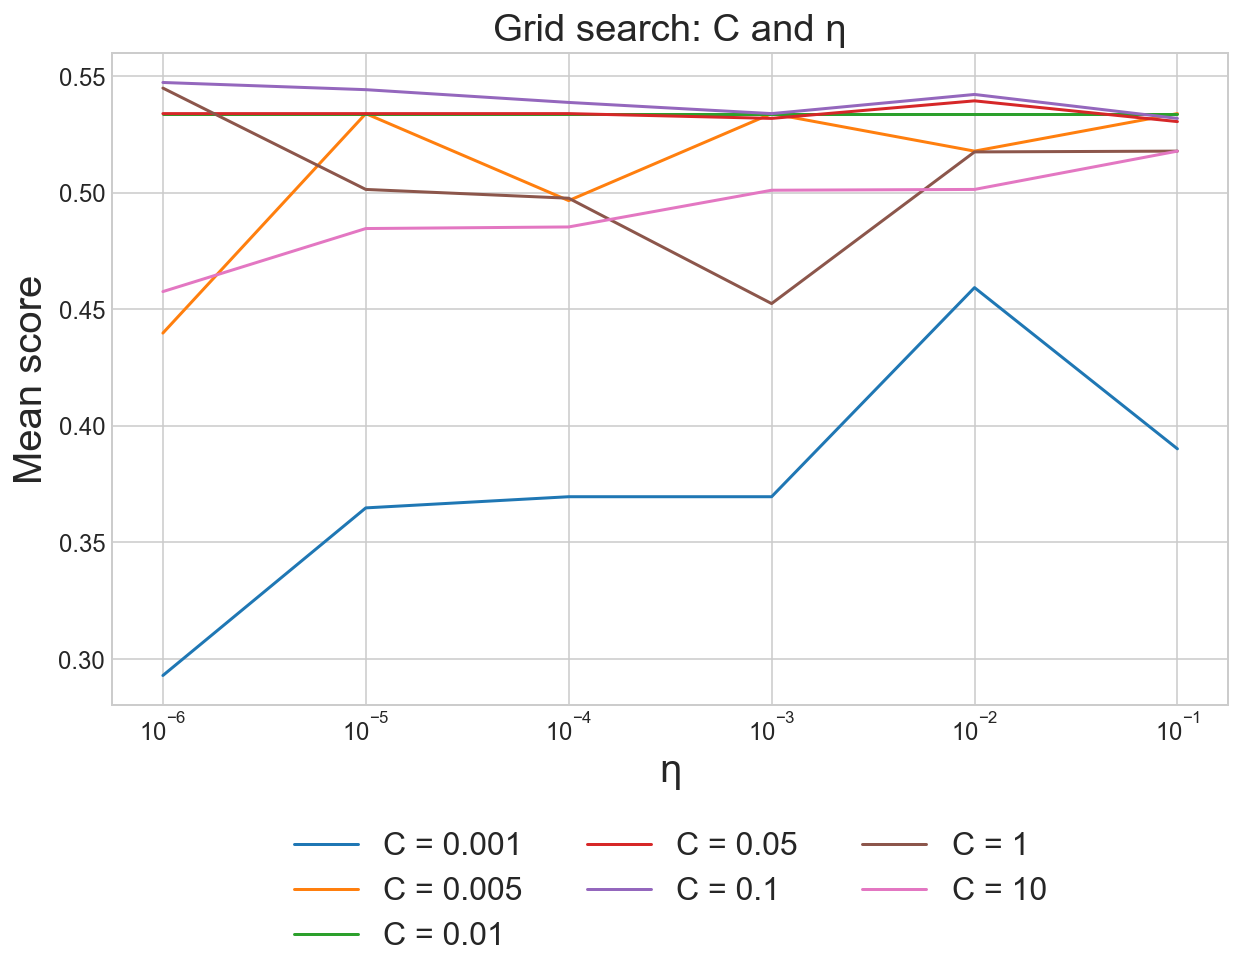

In [35]:
# [CITE] https://stackoverflow.com/a/37163377
# "How to graph grid scores from GridSearchCV?"

scores = gs.cv_results_['mean_test_score']
scores = scores.reshape([*map(len, param_grid.values())])

# plot a line for each cost
# x-axis is eta range, y-axis is score
for index, cost in enumerate(costs):
    plt.semilogx(etas, scores[index], label=f'C = {cost}')
plt.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=3
)
plt.xlabel('η')
plt.ylabel('Mean score')
plt.title('Grid search: C and η');

print('\nEvaluation criteria: accuracy')
print('\nBest hyperparameter settings:',*[f'\t{k} = {v}' for k,v in gs.best_params_.items()],sep='\n')
print(f'\nBest score: {gs.best_score_}\n')

Above we display the best hyperparameters attempted and the resulting score. 54% accuracy is clearly not an ideal score, but for the aforementioned limitations of this classification tasks (due to our labelling issues), we are optimistic about this score. There may be more performant hyperparameter combinations we are not aware of because the precision of our search is limited, but we do not believe that such hyperparameters will result in a significantly greater accuracy score than what we have encountered here.

In [37]:
# fig, ax = plt.subplots()
# plt.plot(np.arange(nn.epochs), nn.cost_)
# plt.title('asdf')
# # plt.ylim(-2.0,0)
# plt.show()

### 4.3 Evaluation and cross validation

Now we analyze the performance of a single instance of our multi-layer perceptron using the hyperparameters generated by the above grid-search procedure—we insert the result directly and procedurally into our new instance. We visualize the performance on our evaluation criteria of each fold on the stratified 10-fold cross validation set.

In [36]:
nn = MultiLayerPerceptron(
    hidden_layer_sizes=[10,10,10],
    l2_C=gs.best_params_['l2_C'], # tradeoff L2 regularizer
    epochs=2000, # iterations
    eta=gs.best_params_['eta'],  # learning rate
    random_state=1,
    alpha=0.001,# momentum calculation
    decrease_const=0.0001, # decreasing eta
    minibatches=50, # minibatch size
    shuffle=True,
    activation_function='sigmoid',
    cost_function='least_squares'
)

In [49]:
from sklearn.model_selection import cross_val_score

In [59]:
%%time
per_fold_eval_criteria = cross_val_score(
    estimator=nn,
    X=X,
    y=y,
    cv=cross_validation,
    scoring=scorer
)

CPU times: user 37.8 s, sys: 3.78 s, total: 41.6 s
Wall time: 35.9 s


Accuracy: 0.55 (+/- 0.05)


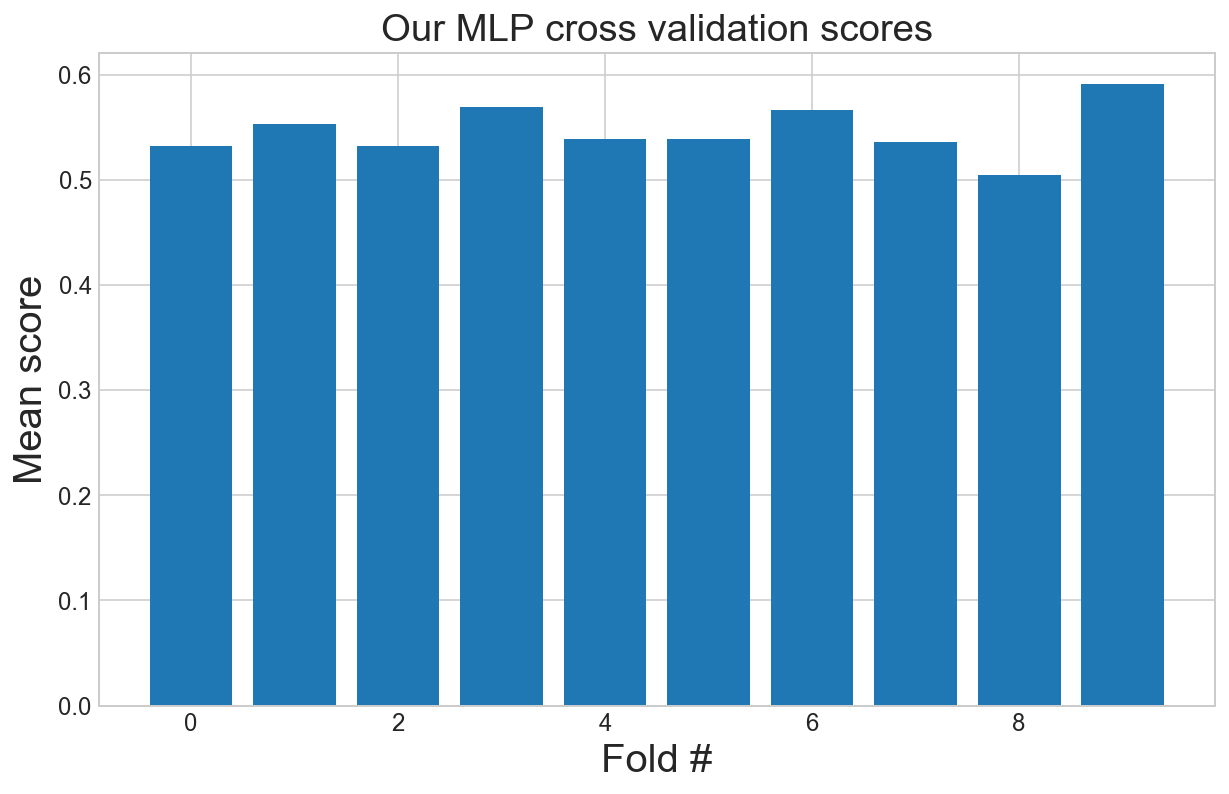

In [58]:
plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.title('Our MLP cross validation scores')
plt.xlabel('Fold #')
plt.ylabel('Mean score')

print("Accuracy: %0.2f (+/- %0.2f)" % (per_fold_eval_criteria.mean(), per_fold_eval_criteria.std() * 2))

### 4.4 Comparison with `scikit-learn`

We will now run through a similar set of tests with `scikit-learn`'s integrated `MLPClassifier`, our competition.

In [52]:
from sklearn.neural_network import MLPClassifier
sknn = MLPClassifier(
    solver='lbfgs',
    hidden_layer_sizes=(10,10,10),
    max_iter=2000, # iterations
    learning_rate_init=0.001,  # learning rate
    learning_rate='invscaling',
    random_state=1,
    alpha=0.001,# momentum calculation
    batch_size=50, # minibatch size
    shuffle=True,
    activation='logistic'
)

In [60]:
%%time
sk_per_fold_eval_criteria = cross_val_score(
    estimator=sknn,
    X=X,
    y=y,
    cv=cross_validation,
    scoring=scorer
)

CPU times: user 2.87 s, sys: 225 ms, total: 3.1 s
Wall time: 2.75 s


Accuracy: 0.54 (+/- 0.05)


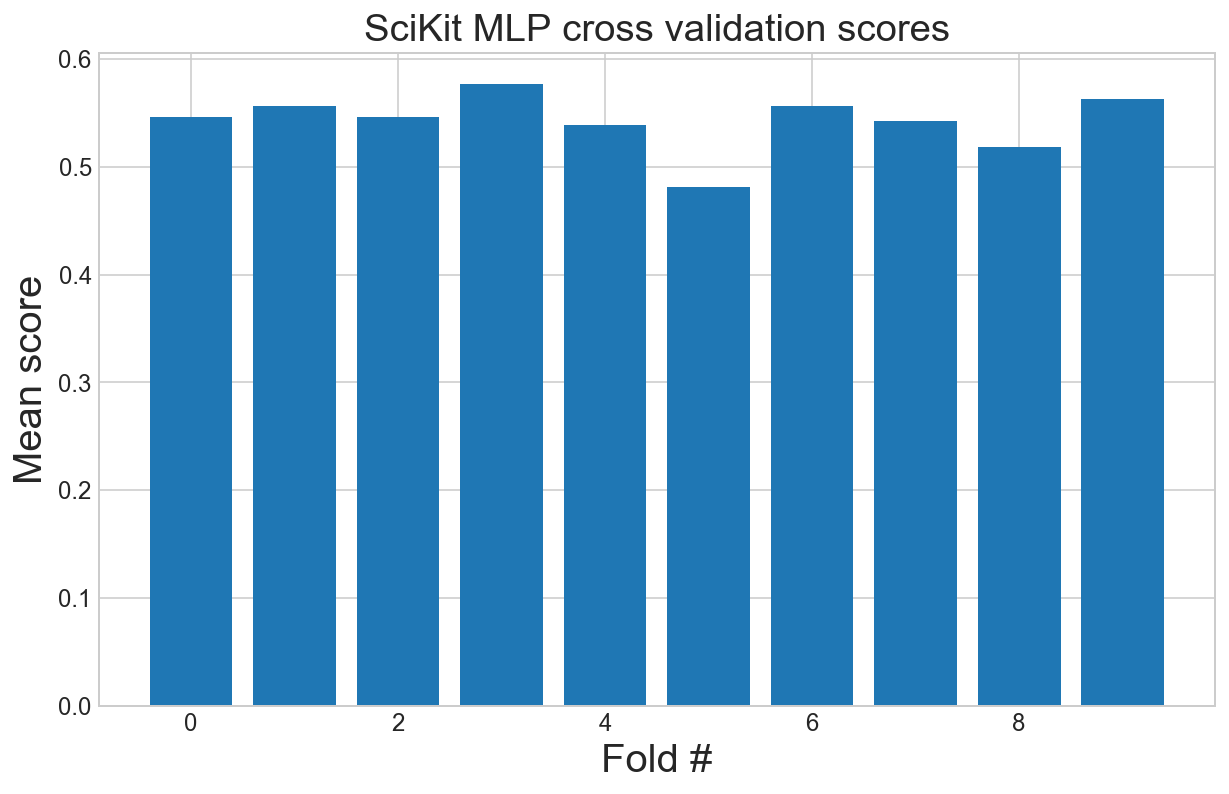

In [54]:
plt.bar(range(len(sk_per_fold_eval_criteria)),sk_per_fold_eval_criteria)
plt.title('SciKit MLP cross validation scores')
plt.xlabel('Fold #')
plt.ylabel('Mean score')

print("Accuracy: %0.2f (+/- %0.2f)" % (sk_per_fold_eval_criteria.mean(), sk_per_fold_eval_criteria.std() * 2))

#### Performance
---
**DRAW:** It appears that our algorithm performs just as well (or more precisely, just as poorly) as `MLPClassifier`. This is a poorly designed classification task (see rationale in Introduction). If tested on something more conventional like handwritten digits, both our algorithm and `MLPClassifier` can reach the high 90's.

#### Computation time
---
```
Testing apparatus:
==================

iMac (Retina 5K, 27-inch, Late 2014)

 Processor: 4 GHz Intel Core i7
    Memory: 16 GB 1600 MHz DDR3
  Graphics: AMD Radeon R9 M295X 4 GB
        OS: macOS High Sierra Version 10.13 (17A405)
        
```

**LOSE:** Our algorithm takes 35 seconds to complete the full cross-evaluation scoring process on the above apparatus, whereas `MLPClassifier` performs the same operation in 2.76 seconds. That's over 12x faster, under ideal conditions that means it is 12x more computationally efficient.

#### Memory use
---
**N/A:** We did not have a readily available tool for profiling this Jupyter notebook formally during the above cross evaluation processes, but during an informal test in which we observed the macOS Activity Monitor during execution, memory topped out at 169.1 MB for our implementation. However, the memory monitor did not update quickly enough to capture python memory usage during the short window of time that the `scikit-learn` implementation was being used in cross-evaluation scoring. Additionally, no memory size gleaned from this process can be meaningful, because **Python does not deterministically free memory**, even when it performs garbage disposal internally: it will retain memory for its process although that memory may not be associated with any data members in the runtime. In the [Python 3 spec](https://docs.python.org/3/reference/simple_stmts.html#the-del-statement), it is not explicitly stated that the `del` command actually frees memory—Python memory profiling is not trivial and thus cannot be completed in a trivial test such as ours.

#### Winner
---
**Scikit-Learn, probably:** our algorithm has much poorer computational efficiency, and while `scikit-learn` is not GPU optimized and does not recommend use of `MLPClassifier` in high-performance or high-scale environments, it still comes out on top as significantly more computationally efficient. In terms of generalization performance, it is reasonable to assume that `MLPClassifier`, with its much larger list of options for optimization functions and other hyperparameters, is capable of beating out our algorithm, a difference that is probably more apparent in *better designed* classification tasks (our fault, see introduction).

## 5. Conclusion

In the face of our faulty classification task (a problem of our own design), we are content with the performance of our multi-layer perceptron implementation, and especially proud of the fact that we were able to generalize its functionality to support arbitrarily-many hidden layers. Nonetheless, we fell far behind our stated target of 80% performance, a target we have never met on this classification task thus far since providing it as a goal in our first project. We wholeheartedly believe that this is a limitation of how we've designed the task (artificially, without regard for clustering, etc.), and not a representation of the quality of our algorithm—we keep the faulty task in place only for consistency with prior reports on this same task. 

Moving forward, if we were to continue developing on this implementation, we would dedicate some time to test for edge cases and other issues; in certain configurations of hyperparameters, we still receive errors like division by zero or arithmetic with `np.nan`. This implementation needs further scrutiny, as well as further effort into computational optimization. The current run time of cross validation scoring against our implementation is unacceptably long relative to the `scikit` implementation. Nonetheless, we are happy with how far we were able to get with very limited understanding of perceptrons under our belt at the outset of this project.

### 5.1 Afterthought

In [70]:
"""
Not to be considered part of the report
Not to be confused with the rest of the report
Not an inadvertent use of a different dataset splitting method

Just proof that our perceptron works well under better conditions
For your consideration
"""

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()

d_X = digits.data/16.0
d_y = digits.target

X_train, X_test, y_train, y_test = train_test_split(d_X,d_y,test_size = 0.2)

nn = MultiLayerPerceptron(
    hidden_layer_sizes=[50], 
    l2_C=0.1, # tradeoff L2 regularizer
    epochs=5000, # iterations
    eta=0.001,  # learning rate
    random_state=1,
    alpha=0.001,# momentum calculation
    decrease_const=0.0001, # decreasing eta
    minibatches=50, # minibatch size
    shuffle=True,
    activation_function='sigmoid',
    cost_function='cross_entropy'
)

nn.fit(X_train, y_train, print_progress=10)
yhat = nn.predict(X_test)

print('A much better representation of the performance of our algorithm:\n')
print(f'{accuracy_score(y_test,yhat):10.3} accuracy. :-)\n')

Epoch: 5000/5000


A much better representation of the performance of our algorithm:

     0.992 accuracy. :-)

